## Prepaid Performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime

## Import Data Source

In [2]:
data_src = "../Raw-Agg Perf Nationwide_Wk 2023021.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']

prepaid_rev_cd_list = ['B1R000100', 'B1R000101', 'B1R000102']
prepaid_dtac_rev_cd_list = ['DB1R000100', 'DB1R000101', 'DB1R000102']
prepaid_tmh_rev_cd_list = ['TB1R000100', 'TB1R000101', 'TB1R000102']
prepaid_all_rev_cd_list = prepaid_rev_cd_list + prepaid_dtac_rev_cd_list + prepaid_tmh_rev_cd_list
prepaid_total_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']

df = df[df['TM_KEY_MTH'] <= 202305] # filter
df = df[df['METRIC_CD'].isin(prepaid_all_rev_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
825,33197,20230529,2023022,202305,20232,2023,Monday,May,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,jutar11,Daily,2023-06-02 17:46:25,Prepaid Revenue
826,33198,20230530,2023022,202305,20232,2023,Tuesday,May,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,jutar11,Daily,2023-06-02 17:46:25,Prepaid Revenue
827,33199,20230531,2023022,202305,20232,2023,Wednesday,May,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,NaN,Daily,2023-06-02 17:46:25,Prepaid Revenue


In [3]:
df.shape
# df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()

(828, 55)

In [4]:
# ''' Find Metric '''
# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Prepaid"]#.reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('Prepaid_Metric.xlsx')
# df_tmp

## Data Preporation

In [5]:
''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

''' Datetime values '''
curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.tail(3)

In [6]:
''' Pivot Rawdata '''
# df_tmp = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'MTH_DESC']]#.reset_index()

''' Pivot Actual by Operator '''
df_rev_act_pivot = df.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
# df_rev_act_pivot.rename(columns=({'Prepaid Revenue': 'ALL_ACTUAL', 'Prepaid Revenue : DTAC': 'DTAC_ACTUAL', 'Prepaid Revenue : TMH': 'TMH_ACTUAL'}), inplace=True)
df_rev_act_pivot.rename(columns=({'Prepaid Existing Revenue': 'ACTUAL_EXIST', 'Prepaid Existing Revenue : DTAC': 'ACTUAL_EXIST_DTAC', 'Prepaid Existing Revenue : TMH': 'ACTUAL_EXIST_TMH',
                                  'Prepaid New Revenue': 'ACTUAL_NEW', 'Prepaid New Revenue : DTAC': 'ACTUAL_NEW_DTAC', 'Prepaid New Revenue : TMH': 'ACTUAL_NEW_TMH',
                                  'Prepaid Revenue': 'ACTUAL', 'Prepaid Revenue : DTAC': 'ACTUAL_DTAC', 'Prepaid Revenue : TMH': 'ACTUAL_TMH'}), inplace=True)

''' Pivot Target by Operator '''
df_rev_tgt_pivot = df.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
# df_rev_tgt_pivot.rename(columns=({'Prepaid Revenue': 'ALL_TARGET', 'Prepaid Revenue : DTAC': 'DTAC_TARGET', 'Prepaid Revenue : TMH': 'TMH_TARGET'}), inplace=True)
df_rev_tgt_pivot.rename(columns=({'Prepaid Existing Revenue': 'TARGET_EXIST', 'Prepaid Existing Revenue : DTAC': 'TARGET_EXIST_DTAC', 'Prepaid Existing Revenue : TMH': 'TARGET_EXIST_TMH',
                                  'Prepaid New Revenue': 'TARGET_NEW', 'Prepaid New Revenue : DTAC': 'TARGET_NEW_DTAC', 'Prepaid New Revenue : TMH': 'TARGET_NEW_TMH',
                                  'Prepaid Revenue': 'TARGET', 'Prepaid Revenue : DTAC': 'TARGET_DTAC', 'Prepaid Revenue : TMH': 'TARGET_TMH'}), inplace=True)

''' Aggregation '''
df_rev_pivot_agg = pd.merge(df_rev_act_pivot, df_rev_tgt_pivot, on='TM_KEY_DAY')
df_rev_pivot_agg['WK_LABEL'] = df_rev_pivot_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_pivot_agg['DAY_LABEL'] = df_rev_pivot_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

# df_rev_pivot_agg.tail(3)
# df_rev_pivot_agg.dtypes

## Monthly : Aggregation

In [7]:
''' Aggregate by month '''
df_rev_mth = df_rev_pivot_agg.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH',
                                                                                          'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH',
                                                                                          'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_mth['%ACHV'] = (df_rev_mth['ACTUAL'] / df_rev_mth['TARGET'])
df_rev_mth['%ACHV_DTAC'] = (df_rev_mth['ACTUAL_DTAC'] / df_rev_mth['TARGET_DTAC'])
df_rev_mth['%ACHV_TMH'] = (df_rev_mth['ACTUAL_TMH'] / df_rev_mth['TARGET_TMH'])
df_rev_mth['GAP'] = df_rev_mth['ACTUAL'] - df_rev_mth['TARGET']
df_rev_mth['GAP_DTAC'] = df_rev_mth['ACTUAL_DTAC'] - df_rev_mth['TARGET_DTAC']
df_rev_mth['GAP_TMH'] = df_rev_mth['ACTUAL_TMH'] - df_rev_mth['TARGET_TMH']
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL'].diff()
df_rev_mth['DIFF_DTAC'] = df_rev_mth['ACTUAL_DTAC'].diff()
df_rev_mth['DIFF_TMH'] = df_rev_mth['ACTUAL_TMH'].diff()
df_rev_mth['LAST_ACT'] = df_rev_mth['ACTUAL'] - df_rev_mth['DIFF']
df_rev_mth['LAST_ACT_DTAC'] = df_rev_mth['ACTUAL_DTAC'] - df_rev_mth['DIFF_DTAC']
df_rev_mth['LAST_ACT_TMH'] = df_rev_mth['ACTUAL_TMH'] - df_rev_mth['DIFF_TMH']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL'] / df_rev_mth['LAST_ACT']) - 1
df_rev_mth['%MOM_DTAC'] = (df_rev_mth['ACTUAL_DTAC'] / df_rev_mth['LAST_ACT_DTAC']) - 1
df_rev_mth['%MOM_TMH'] = (df_rev_mth['ACTUAL_TMH'] / df_rev_mth['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_mth['%ACHV_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['TARGET_NEW'])
df_rev_mth['%ACHV_NEW_DTAC'] = (df_rev_mth['ACTUAL_NEW_DTAC'] / df_rev_mth['TARGET_NEW_DTAC'])
df_rev_mth['%ACHV_NEW_TMH'] = (df_rev_mth['ACTUAL_NEW_TMH'] / df_rev_mth['TARGET_NEW_TMH'])
df_rev_mth['GAP_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['TARGET_NEW']
df_rev_mth['GAP_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'] - df_rev_mth['TARGET_NEW_DTAC']
df_rev_mth['GAP_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'] - df_rev_mth['TARGET_NEW_TMH']
df_rev_mth['DIFF_NEW'] = df_rev_mth['ACTUAL_NEW'].diff()
df_rev_mth['DIFF_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'].diff()
df_rev_mth['DIFF_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'].diff()
df_rev_mth['LAST_ACT_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['DIFF_NEW']
df_rev_mth['LAST_ACT_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'] - df_rev_mth['DIFF_NEW_DTAC']
df_rev_mth['LAST_ACT_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'] - df_rev_mth['DIFF_NEW_TMH']
df_rev_mth['%MOM_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['LAST_ACT_NEW']) - 1
df_rev_mth['%MOM_NEW_DTAC'] = (df_rev_mth['ACTUAL_NEW_DTAC'] / df_rev_mth['LAST_ACT_NEW_DTAC']) - 1
df_rev_mth['%MOM_NEW_TMH'] = (df_rev_mth['ACTUAL_NEW_TMH'] / df_rev_mth['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_mth['%ACHV_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['TARGET_EXIST'])
df_rev_mth['%ACHV_EXIST_DTAC'] = (df_rev_mth['ACTUAL_EXIST_DTAC'] / df_rev_mth['TARGET_EXIST_DTAC'])
df_rev_mth['%ACHV_EXIST_TMH'] = (df_rev_mth['ACTUAL_EXIST_TMH'] / df_rev_mth['TARGET_EXIST_TMH'])
df_rev_mth['GAP_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['TARGET_EXIST']
df_rev_mth['GAP_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'] - df_rev_mth['TARGET_EXIST_DTAC']
df_rev_mth['GAP_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'] - df_rev_mth['TARGET_EXIST_TMH']
df_rev_mth['DIFF_EXIST'] = df_rev_mth['ACTUAL_EXIST'].diff()
df_rev_mth['DIFF_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'].diff()
df_rev_mth['DIFF_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'].diff()
df_rev_mth['LAST_ACT_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['DIFF_EXIST']
df_rev_mth['LAST_ACT_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'] - df_rev_mth['DIFF_EXIST_DTAC']
df_rev_mth['LAST_ACT_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'] - df_rev_mth['DIFF_EXIST_TMH']
df_rev_mth['%MOM_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['LAST_ACT_EXIST']) - 1
df_rev_mth['%MOM_EXIST_DTAC'] = (df_rev_mth['ACTUAL_EXIST_DTAC'] / df_rev_mth['LAST_ACT_EXIST_DTAC']) - 1
df_rev_mth['%MOM_EXIST_TMH'] = (df_rev_mth['ACTUAL_EXIST_TMH'] / df_rev_mth['LAST_ACT_EXIST_TMH']) - 1

df_rev_mth
# df_rev_mth.to_excel("temp.xlsx")

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,ACTUAL_NEW,ACTUAL_NEW_DTAC,...,GAP_EXIST_TMH,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%MOM_EXIST,%MOM_EXIST_DTAC,%MOM_EXIST_TMH
0,202303,March,3683.557615,1620.241312,2063.316303,3697.837414,1655.402410,2042.435004,705.278407,378.875050,...,27.253383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202304,April,3584.677321,1569.575558,2015.101763,3639.376740,1590.276264,2049.100476,803.783720,424.846311,...,-21.480938,-197.385607,-96.637014,-100.748592,2978.279208,1241.366262,1736.912946,-0.066275,-0.077847,-0.058004
2,202305,May,3580.122249,1610.280929,2034.107694,3557.837224,1629.597517,1989.658996,891.151522,477.374727,...,7.706399,-91.922874,-11.823046,-35.164230,2780.893601,1144.729248,1636.164354,-0.033055,-0.010328,-0.021492


In [8]:
''' Month Chart Values '''
x = df_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_mth['ACTUAL'].round(2)
y_act_dtac = df_rev_mth['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_mth['ACTUAL_TMH'].round(2)
y_tgt = df_rev_mth['TARGET'].round(2)
y_tgt_dtac = df_rev_mth['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_mth['TARGET_TMH'].round(2)
y_achv = df_rev_mth['%ACHV']
y_achv_dtac = df_rev_mth['%ACHV_DTAC']
y_achv_tmh = df_rev_mth['%ACHV_TMH']
y_gap = df_rev_mth['GAP'].round(2)
y_gap_dtac = df_rev_mth['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_mth['GAP_TMH'].round(2)
y_diff = df_rev_mth['DIFF'].round(2)
y_diff_dtac = df_rev_mth['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_mth['DIFF_TMH'].round(2)
y_last_act = df_rev_mth['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_mth['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_mth['LAST_ACT_TMH'].round(2)
y_mom = df_rev_mth['%MOM']
y_mom_dtac = df_rev_mth['%MOM_DTAC']
y_mom_tmh = df_rev_mth['%MOM_TMH']

''' NEW : Values '''
y_act_new = df_rev_mth['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_mth['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_mth['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_mth['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_mth['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_mth['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_mth['%ACHV_NEW']
y_achv_new_dtac = df_rev_mth['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_mth['%ACHV_NEW_TMH']
y_gap_new = df_rev_mth['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_mth['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_mth['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_mth['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_mth['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_mth['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_mth['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_mth['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_mth['LAST_ACT_NEW_TMH'].round(2)
y_mom_new = df_rev_mth['%MOM_NEW']
y_mom_new_dtac = df_rev_mth['%MOM_NEW_DTAC']
y_mom_new_tmh = df_rev_mth['%MOM_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_mth['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_mth['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_mth['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_mth['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_mth['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_mth['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_mth['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_mth['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_mth['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_mth['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_mth['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_mth['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_mth['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_mth['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_mth['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_mth['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_mth['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_mth['LAST_ACT_EXIST_TMH'].round(2)
y_mom_exist = df_rev_mth['%MOM_EXIST']
y_mom_exist_dtac = df_rev_mth['%MOM_EXIST_DTAC']
y_mom_exist_tmh = df_rev_mth['%MOM_EXIST_TMH']

### Prepaid Revenue Summary : MTH

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/2442845827.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[:, 0])
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/2442845827.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[:, 1:])


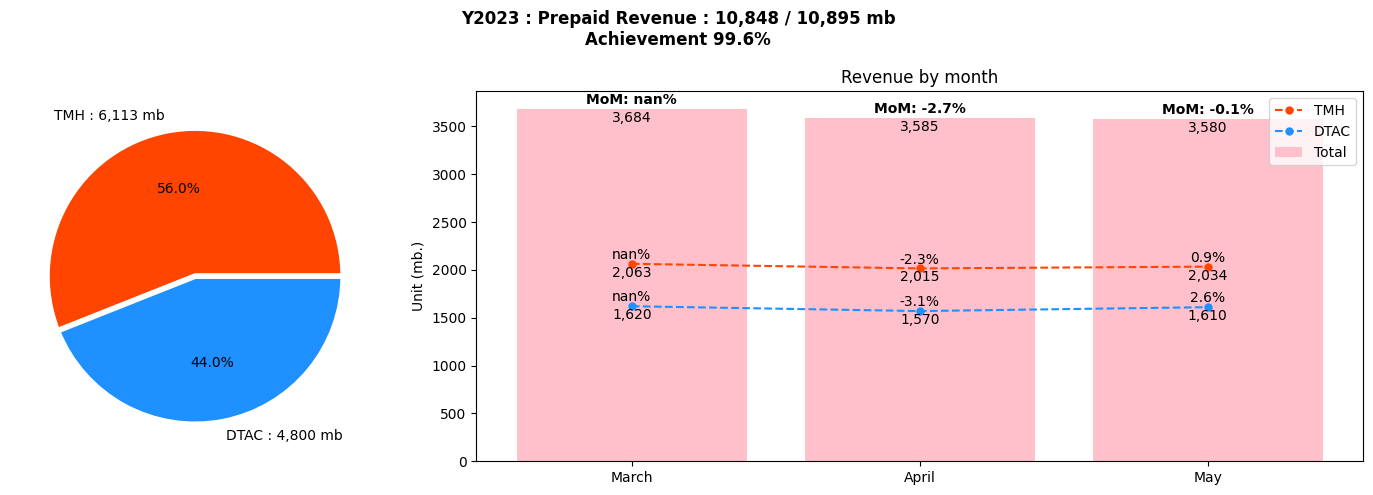

In [9]:
''' Revenue Summary : MTH Chart '''
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
fig.suptitle(f"Y{curr_yr} : Prepaid Revenue : {format(sum(y_act),',.0f')} / {format(sum(y_tgt),',.0f')} mb\nAchievement {format(sum(y_act)/sum(y_tgt),',.1%')}", weight='bold')

gs = GridSpec(1, 3)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:, 1:])

''' ax1 '''
y = np.array([sum(y_act_tmh), sum(y_act_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})

''' ax2 '''
ax2.set_title('Revenue by month')
ax2.bar(x, y_act, label='Total', color='pink')
ax2.plot(x, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
ax2.plot(x, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    ax2.annotate(f"MoM: {format(y_mom[i],',.1%')}", xy=(x_axis[i], y_act[i]+20), ha='center', va='bottom', weight='bold')
    ax2.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]-20), ha='center', va='top')
    ax2.annotate(f"{format(y_mom_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+20), ha='center', va='bottom')
    ax2.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-20), ha='center', va='top')
    ax2.annotate(f"{format(y_mom_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+20), ha='center', va='bottom')
    ax2.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-20), ha='center', va='top')
ax2.set_ylabel('Unit (mb.)', fontsize=10)
# ax2.grid(alpha=0.2)
ax2.legend()

fig.tight_layout()
plt.show()

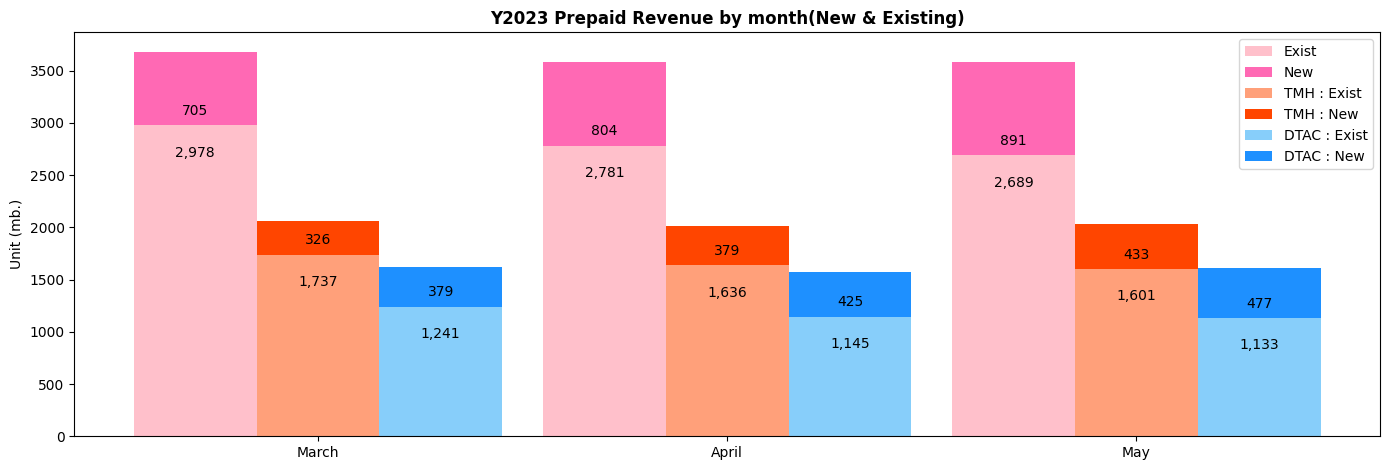

In [10]:
''' Revenue with New & Existing : MTH Chart '''
plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3
# f"Y{curr_yr} : Prepaid Revenue : {format(sum(y_act),',.0f')} mb", weight='bold'
plt.title(f'Y{curr_yr} Prepaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})

plt.bar(x_axis-diff_loc, y_act_exist, width, label='Exist', color='pink')
plt.bar(x_axis-diff_loc, y_act_new, width, label='New', color='hotpink', bottom=y_act_exist)
plt.bar(x_axis, y_act_exist_tmh, width, label='TMH : Exist', color='lightsalmon')
plt.bar(x_axis, y_act_new_tmh, width, label='TMH : New', color='orangered', bottom=y_act_exist_tmh)
plt.bar(x_axis+diff_loc, y_act_exist_dtac, width, label='DTAC : Exist', color='lightskyblue')
plt.bar(x_axis+diff_loc, y_act_new_dtac, width, label='DTAC : New', color='dodgerblue', bottom=y_act_exist_dtac)

for i in x_axis:    
    plt.annotate(format(y_act_exist[i],',.0f'), xy=(x_axis[i]-diff_loc, y_act_exist[i]-300), ha='center')
    plt.annotate(format(y_act_new[i],',.0f'), xy=(x_axis[i]-diff_loc, y_act_exist[i]+100), ha='center')
    plt.annotate(format(y_act_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]-300), ha='center')
    plt.annotate(format(y_act_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]+100), ha='center')
    plt.annotate(format(y_act_exist_dtac[i],',.0f'), xy=(x_axis[i]+diff_loc, y_act_exist_dtac[i]-300), ha='center')
    plt.annotate(format(y_act_new_dtac[i],',.0f'), xy=(x_axis[i]+diff_loc, y_act_exist_dtac[i]+100), ha='center')

plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

### Prepaid Revenue : TMH vs DTAC : MTH

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/3181751703.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[:, 0])


Text(0.5, 0, 'DTAC')

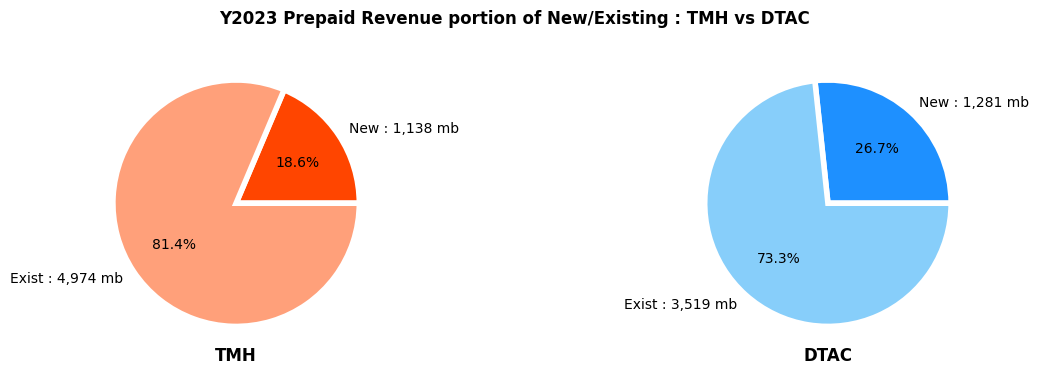

In [11]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 4))
fig.suptitle(f'Y{curr_yr} Prepaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')

gs = GridSpec(1, 2)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_act_new_tmh), sum(y_act_exist_tmh)])
mylabels = [f"New : {format(y[0],',.0f')} mb", f"Exist : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_title('TMH', y=0, pad=-2, weight='bold')

''' ax2 '''
y = np.array([sum(y_act_new_dtac), sum(y_act_exist_dtac)])
mylabels = [f"New : {format(y[0],',.0f')} mb", f"Exist : {format(y[1],',.0f')} mb"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_title('DTAC', y=0, pad=-2, weight='bold')

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/456825233.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[1, 0])
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/456825233.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[2, 0])
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_4371/456825233.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(gs[0, :])


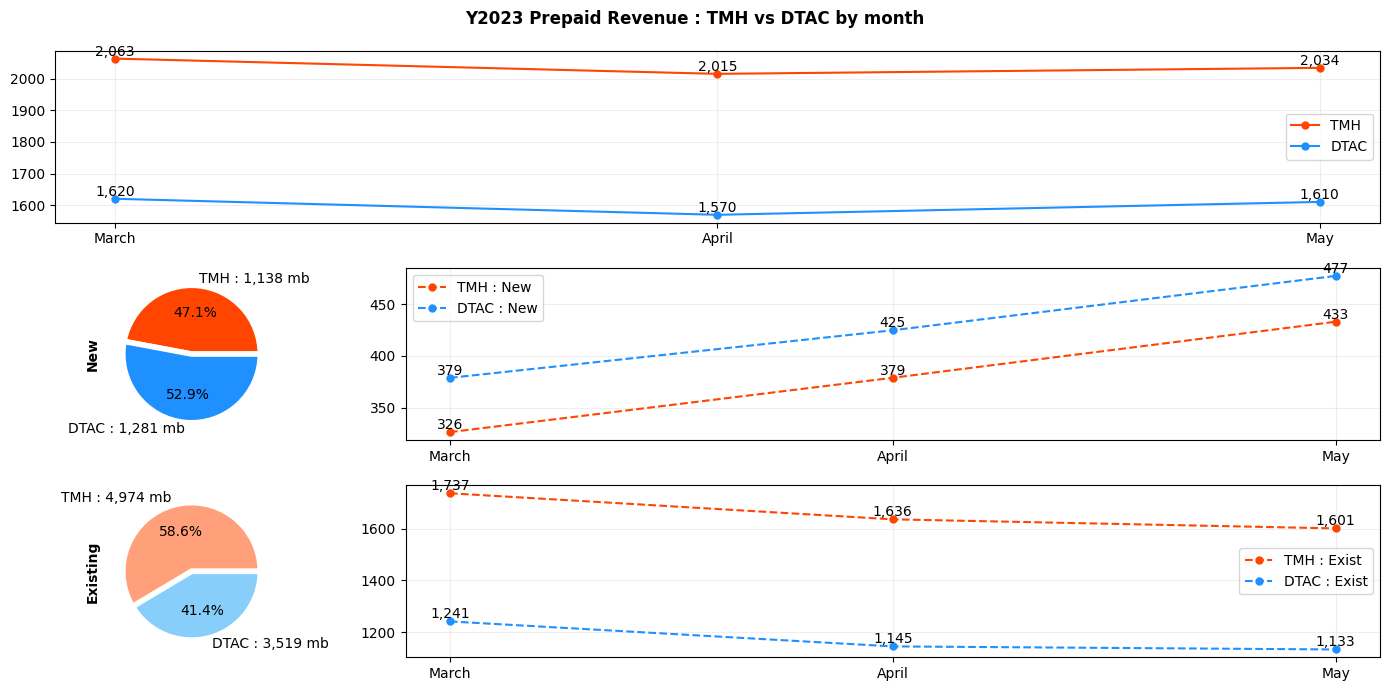

In [12]:
''' Revenue : TMH vs DTAC : MTH Chart '''
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid Revenue : TMH vs DTAC by month', weight='bold')

gs = GridSpec(3, 4)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[2, 0])
ax3 = plt.subplot(gs[0, :])
ax4 = plt.subplot(gs[1, 1:])
ax5 = plt.subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_act_new_tmh), sum(y_act_new_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_act_exist_tmh), sum(y_act_exist_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x, y_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x, y_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]), ha='center', va='bottom')
    ax3.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]), ha='center', va='bottom')

''' ax4 '''
ax4.plot(x, y_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH : New', color='orangered')
ax4.plot(x, y_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC : New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.2)
for i in x_axis:
    ax4.annotate(format(y_act_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_new_tmh[i]), ha='center', va='bottom')
    ax4.annotate(format(y_act_new_dtac[i],',.0f'), xy=(x_axis[i], y_act_new_dtac[i]), ha='center', va='bottom')

''' ax5 '''
ax5.plot(x, y_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH : Exist', color='orangered')
ax5.plot(x, y_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC : Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.2)
for i in x_axis:
    ax5.annotate(format(y_act_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]), ha='center', va='bottom')
    ax5.annotate(format(y_act_exist_dtac[i],',.0f'), xy=(x_axis[i], y_act_exist_dtac[i]), ha='center', va='bottom')

# fig.supylabel('Revenue (mb.)', fontsize=10)
fig.tight_layout()
plt.show()

### Prepaid Performance : %Achievement & Gap : MTH

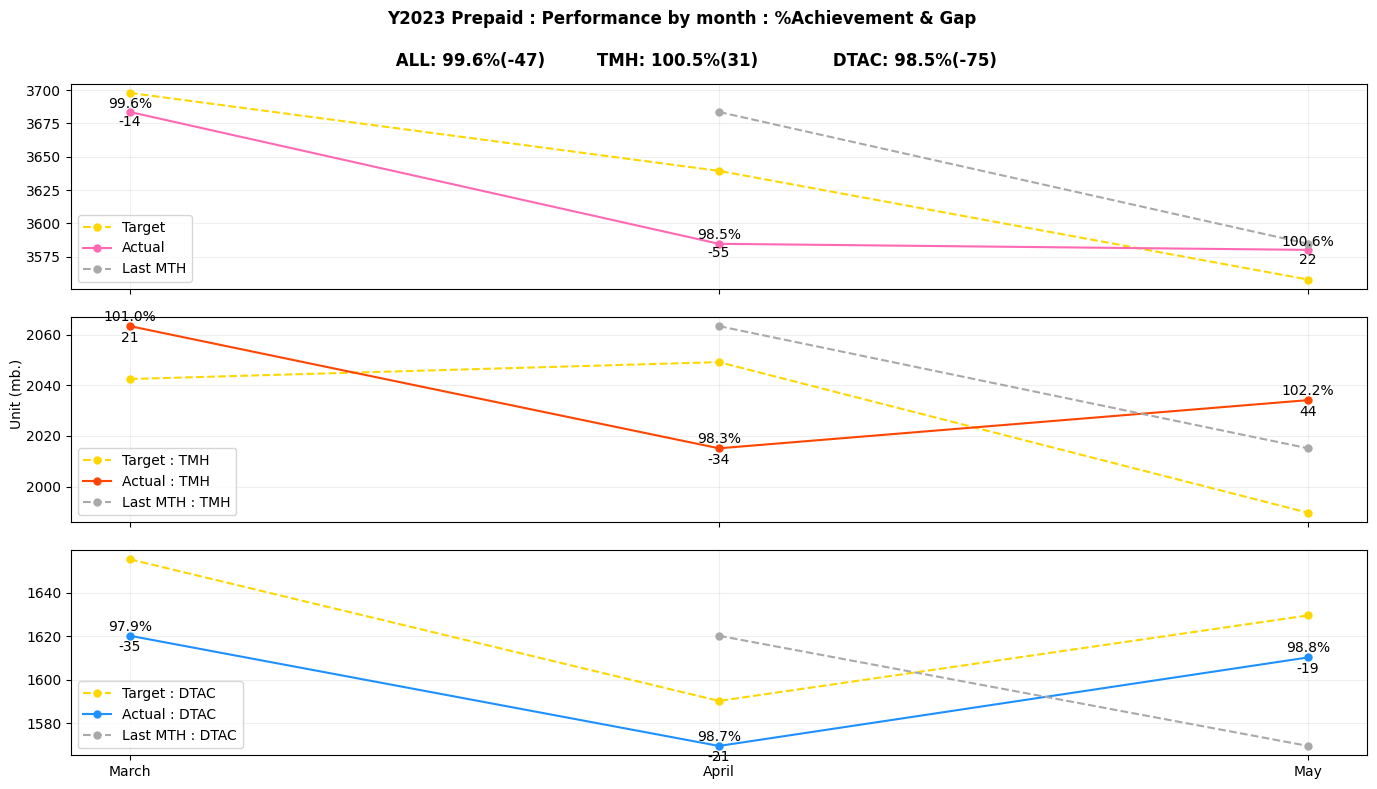

In [13]:
''' Peformance : %Achievement & Gap : MTH Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Prepaid : Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_act)/sum(y_tgt),',.1%')}({format(sum(y_gap),',.0f')}) \
        TMH: {format(sum(y_act_tmh)/sum(y_tgt_tmh),',.1%')}({format(sum(y_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_act_dtac)/sum(y_tgt_dtac),',.1%')}({format(sum(y_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x, y_act, marker='.', markeredgewidth=3, label='Actual', color='hotpink')
ax1.plot(x, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend(loc='lower left')
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv[i],',.1%'), xy=(x_axis[i], y_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap[i],',.0f'), xy=(x_axis[i], y_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_tmh[i],',.1%'), xy=(x_axis[i], y_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_dtac[i],',.1%'), xy=(x_axis[i], y_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.show()

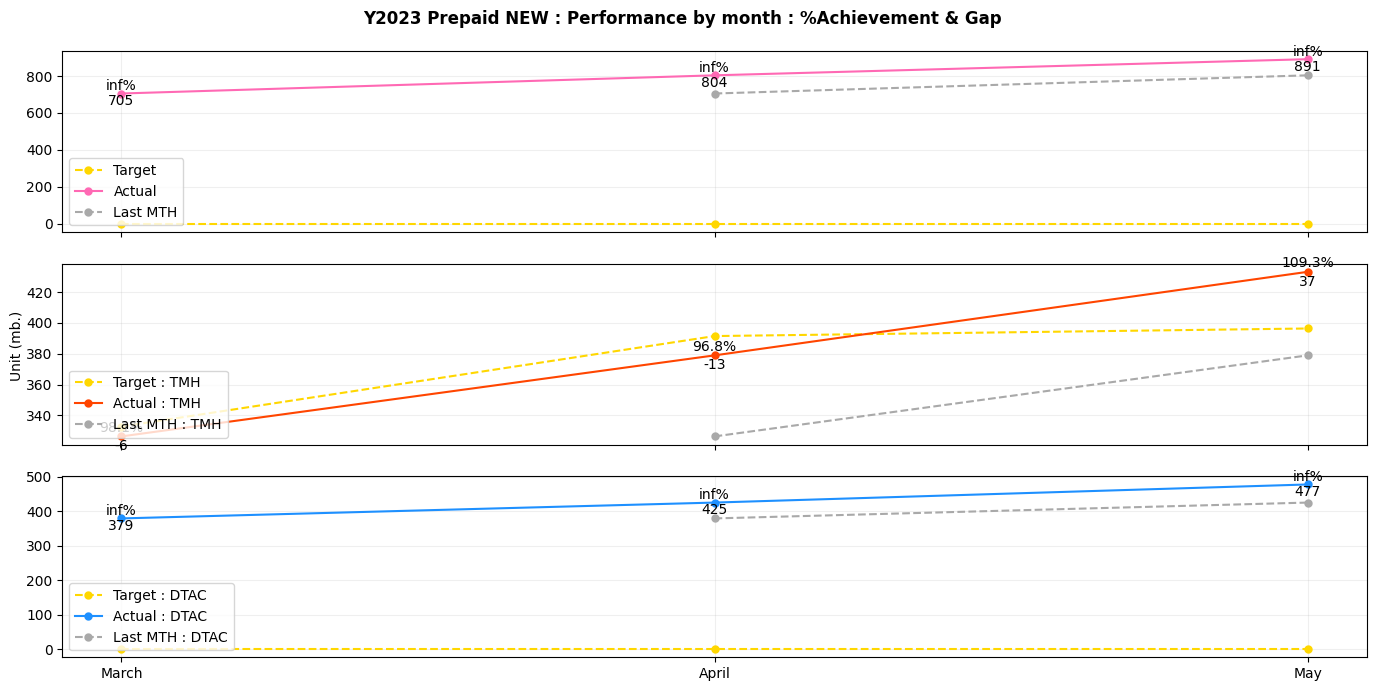

In [14]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid NEW : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x, y_act_new, marker='.', markeredgewidth=3, label='Actual', color='hotpink')
ax1.plot(x, y_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend(loc='lower left')
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv_new[i],',.1%'), xy=(x_axis[i], y_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap_new[i],',.0f'), xy=(x_axis[i], y_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x, y_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x, y_act_new_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x, y_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_new_tmh[i],',.1%'), xy=(x_axis[i], y_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x, y_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x, y_act_new_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x, y_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_new_dtac[i],',.1%'), xy=(x_axis[i], y_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_new_dtac[i],',.0f'), xy=(x_axis[i], y_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.show()

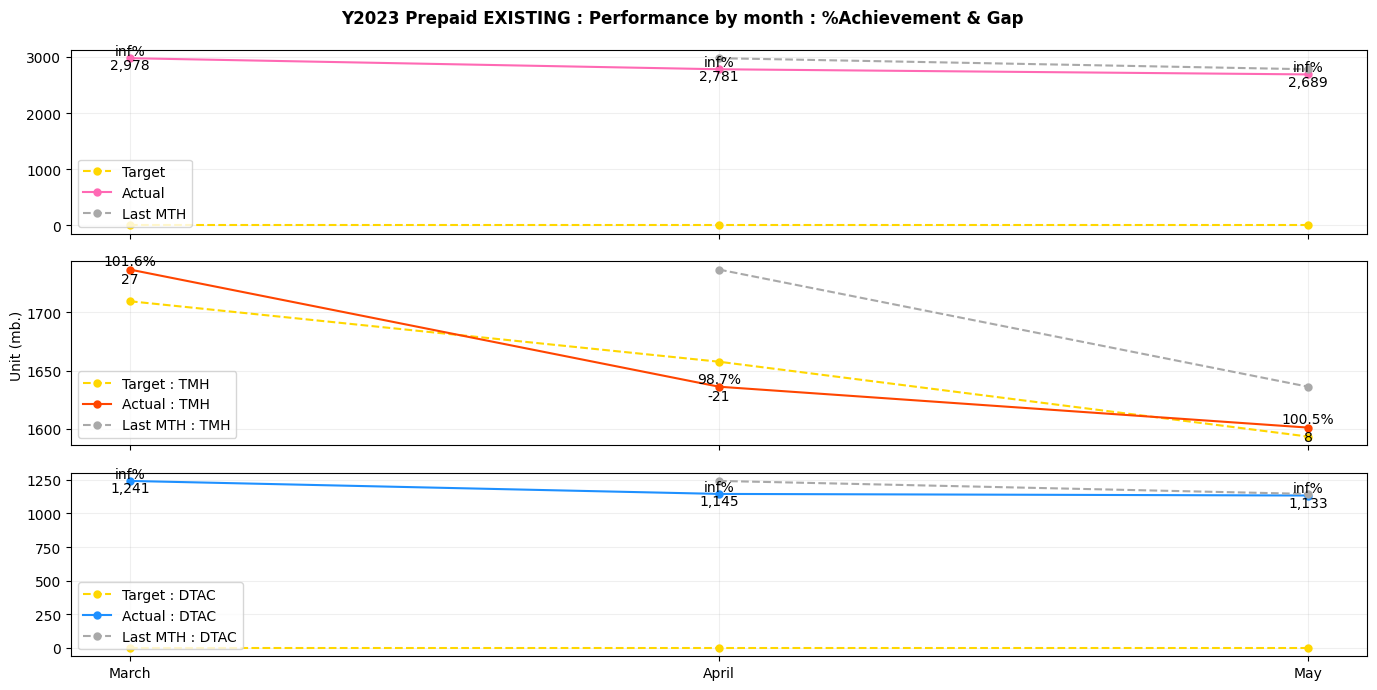

In [15]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid EXISTING : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x, y_act_exist, marker='.', markeredgewidth=3, label='Actual', color='hotpink')
ax1.plot(x, y_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend(loc='lower left')
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv_exist[i],',.1%'), xy=(x_axis[i], y_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap_exist[i],',.0f'), xy=(x_axis[i], y_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x, y_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x, y_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x, y_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_exist_tmh[i],',.1%'), xy=(x_axis[i], y_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x, y_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x, y_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x, y_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_exist_dtac[i],',.1%'), xy=(x_axis[i], y_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_exist_dtac[i],',.0f'), xy=(x_axis[i], y_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.show()

## Weekly : Aggregation

In [16]:
''' Aggregate by week '''
df_rev_wk = df_rev_pivot_agg.groupby('WK_LABEL').sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH', 
                                                                          'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH', 
                                                                          'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_wk['%ACHV'] = (df_rev_wk['ACTUAL'] / df_rev_wk['TARGET'])
df_rev_wk['%ACHV_DTAC'] = (df_rev_wk['ACTUAL_DTAC'] / df_rev_wk['TARGET_DTAC'])
df_rev_wk['%ACHV_TMH'] = (df_rev_wk['ACTUAL_TMH'] / df_rev_wk['TARGET_TMH'])
df_rev_wk['GAP'] = df_rev_wk['ACTUAL'] - df_rev_wk['TARGET']
df_rev_wk['GAP_DTAC'] = df_rev_wk['ACTUAL_DTAC'] - df_rev_wk['TARGET_DTAC']
df_rev_wk['GAP_TMH'] = df_rev_wk['ACTUAL_TMH'] - df_rev_wk['TARGET_TMH']
df_rev_wk['DIFF'] = df_rev_wk['ACTUAL'].diff()
df_rev_wk['DIFF_DTAC'] = df_rev_wk['ACTUAL_DTAC'].diff()
df_rev_wk['DIFF_TMH'] = df_rev_wk['ACTUAL_TMH'].diff()
df_rev_wk['LAST_ACT'] = df_rev_wk['ACTUAL'] - df_rev_wk['DIFF']
df_rev_wk['LAST_ACT_DTAC'] = df_rev_wk['ACTUAL_DTAC'] - df_rev_wk['DIFF_DTAC']
df_rev_wk['LAST_ACT_TMH'] = df_rev_wk['ACTUAL_TMH'] - df_rev_wk['DIFF_TMH']
df_rev_wk['%WOW'] = (df_rev_wk['ACTUAL'] / df_rev_wk['LAST_ACT']) - 1
df_rev_wk['%WOW_DTAC'] = (df_rev_wk['ACTUAL_DTAC'] / df_rev_wk['LAST_ACT_DTAC']) - 1
df_rev_wk['%WOW_TMH'] = (df_rev_wk['ACTUAL_TMH'] / df_rev_wk['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_wk['%ACHV_NEW'] = (df_rev_wk['ACTUAL_NEW'] / df_rev_wk['TARGET_NEW'])
df_rev_wk['%ACHV_NEW_DTAC'] = (df_rev_wk['ACTUAL_NEW_DTAC'] / df_rev_wk['TARGET_NEW_DTAC'])
df_rev_wk['%ACHV_NEW_TMH'] = (df_rev_wk['ACTUAL_NEW_TMH'] / df_rev_wk['TARGET_NEW_TMH'])
df_rev_wk['GAP_NEW'] = df_rev_wk['ACTUAL_NEW'] - df_rev_wk['TARGET_NEW']
df_rev_wk['GAP_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'] - df_rev_wk['TARGET_NEW_DTAC']
df_rev_wk['GAP_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'] - df_rev_wk['TARGET_NEW_TMH']
df_rev_wk['DIFF_NEW'] = df_rev_wk['ACTUAL_NEW'].diff()
df_rev_wk['DIFF_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'].diff()
df_rev_wk['DIFF_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'].diff()
df_rev_wk['LAST_ACT_NEW'] = df_rev_wk['ACTUAL_NEW'] - df_rev_wk['DIFF_NEW']
df_rev_wk['LAST_ACT_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'] - df_rev_wk['DIFF_NEW_DTAC']
df_rev_wk['LAST_ACT_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'] - df_rev_wk['DIFF_NEW_TMH']
df_rev_wk['%WOW_NEW'] = (df_rev_wk['ACTUAL_NEW'] / df_rev_wk['LAST_ACT_NEW']) - 1
df_rev_wk['%WOW_NEW_DTAC'] = (df_rev_wk['ACTUAL_NEW_DTAC'] / df_rev_wk['LAST_ACT_NEW_DTAC']) - 1
df_rev_wk['%WOW_NEW_TMH'] = (df_rev_wk['ACTUAL_NEW_TMH'] / df_rev_wk['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_wk['%ACHV_EXIST'] = (df_rev_wk['ACTUAL_EXIST'] / df_rev_wk['TARGET_EXIST'])
df_rev_wk['%ACHV_EXIST_DTAC'] = (df_rev_wk['ACTUAL_EXIST_DTAC'] / df_rev_wk['TARGET_EXIST_DTAC'])
df_rev_wk['%ACHV_EXIST_TMH'] = (df_rev_wk['ACTUAL_EXIST_TMH'] / df_rev_wk['TARGET_EXIST_TMH'])
df_rev_wk['GAP_EXIST'] = df_rev_wk['ACTUAL_EXIST'] - df_rev_wk['TARGET_EXIST']
df_rev_wk['GAP_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'] - df_rev_wk['TARGET_EXIST_DTAC']
df_rev_wk['GAP_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'] - df_rev_wk['TARGET_EXIST_TMH']
df_rev_wk['DIFF_EXIST'] = df_rev_wk['ACTUAL_EXIST'].diff()
df_rev_wk['DIFF_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'].diff()
df_rev_wk['DIFF_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'].diff()
df_rev_wk['LAST_ACT_EXIST'] = df_rev_wk['ACTUAL_EXIST'] - df_rev_wk['DIFF_EXIST']
df_rev_wk['LAST_ACT_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'] - df_rev_wk['DIFF_EXIST_DTAC']
df_rev_wk['LAST_ACT_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'] - df_rev_wk['DIFF_EXIST_TMH']
df_rev_wk['%WOW_EXIST'] = (df_rev_wk['ACTUAL_EXIST'] / df_rev_wk['LAST_ACT_EXIST']) - 1
df_rev_wk['%WOW_EXIST_DTAC'] = (df_rev_wk['ACTUAL_EXIST_DTAC'] / df_rev_wk['LAST_ACT_EXIST_DTAC']) - 1
df_rev_wk['%WOW_EXIST_TMH'] = (df_rev_wk['ACTUAL_EXIST_TMH'] / df_rev_wk['LAST_ACT_EXIST_TMH']) - 1

df_rev_wk.tail(3)
# df_rev_wk.to_excel("temp.xlsx")

METRIC_NAME,WK_LABEL,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,ACTUAL_NEW,ACTUAL_NEW_DTAC,ACTUAL_NEW_TMH,...,GAP_EXIST_TMH,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%WOW_EXIST,%WOW_EXIST_DTAC,%WOW_EXIST_TMH
11,20,809.668670,349.633265,460.035405,819.748714,355.494948,464.253766,205.469651,105.198108,100.271543,...,-12.004675,-4.204399,-3.030098,-1.174301,608.403418,247.465255,360.938162,-0.006911,-0.012245,-0.003253
12,21,817.699159,350.000495,467.698664,814.678824,350.425058,464.253766,211.226809,108.796178,102.430631,...,-6.500503,2.273332,-3.230840,5.504172,604.199019,244.435157,359.763861,0.003763,-0.013218,0.015299
13,22,255.949034,170.356826,149.858581,240.757117,169.532473,132.643933,62.181642,50.070741,31.441677,...,12.197323,-412.704958,-120.918232,-246.851128,606.472350,241.204317,365.268033,-0.680501,-0.501310,-0.675808


In [17]:
''' Week Chart Values '''
x = df_rev_wk['WK_LABEL']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_wk['ACTUAL'].round(2)
y_act_dtac = df_rev_wk['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_wk['ACTUAL_TMH'].round(2)
y_tgt = df_rev_wk['TARGET'].round(2)
y_tgt_dtac = df_rev_wk['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_wk['TARGET_TMH'].round(2)
y_achv = df_rev_wk['%ACHV']
y_achv_dtac = df_rev_wk['%ACHV_DTAC']
y_achv_tmh = df_rev_wk['%ACHV_TMH']
y_gap = df_rev_wk['GAP'].round(2)
y_gap_dtac = df_rev_wk['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_wk['GAP_TMH'].round(2)
y_diff = df_rev_wk['DIFF'].round(2)
y_diff_dtac = df_rev_wk['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_wk['DIFF_TMH'].round(2)
y_last_act = df_rev_wk['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_wk['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_wk['LAST_ACT_TMH'].round(2)
y_wow = df_rev_wk['%WOW']
y_wow_dtac = df_rev_wk['%WOW_DTAC']
y_wow_tmh = df_rev_wk['%WOW_TMH']

''' NEW : Values '''
y_act_new = df_rev_wk['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_wk['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_wk['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_wk['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_wk['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_wk['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_wk['%ACHV_NEW']
y_achv_new_dtac = df_rev_wk['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_wk['%ACHV_NEW_TMH']
y_gap_new = df_rev_wk['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_wk['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_wk['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_wk['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_wk['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_wk['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_wk['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_wk['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_wk['LAST_ACT_NEW_TMH'].round(2)
y_wow_new = df_rev_wk['%WOW_NEW']
y_wow_new_dtac = df_rev_wk['%WOW_NEW_DTAC']
y_wow_new_tmh = df_rev_wk['%WOW_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_wk['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_wk['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_wk['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_wk['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_wk['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_wk['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_wk['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_wk['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_wk['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_wk['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_wk['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_wk['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_wk['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_wk['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_wk['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_wk['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_wk['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_wk['LAST_ACT_EXIST_TMH'].round(2)
y_wow_exist = df_rev_wk['%WOW_EXIST']
y_wow_exist_dtac = df_rev_wk['%WOW_EXIST_DTAC']
y_wow_exist_tmh = df_rev_wk['%WOW_EXIST_TMH']

### Prepaid Revenue Summary : WK

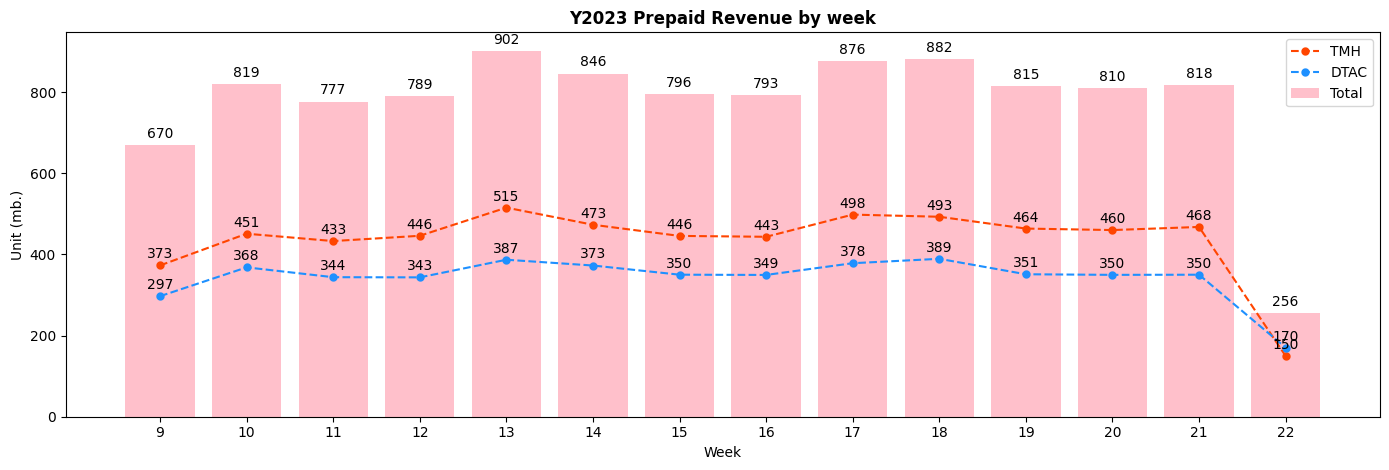

In [18]:
''' Revenue by week '''
plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Prepaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_axis, y_act, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]+10), ha='center', va='bottom')
    plt.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]+10), ha='center', va='bottom')
    plt.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]+10), ha='center', va='bottom')
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

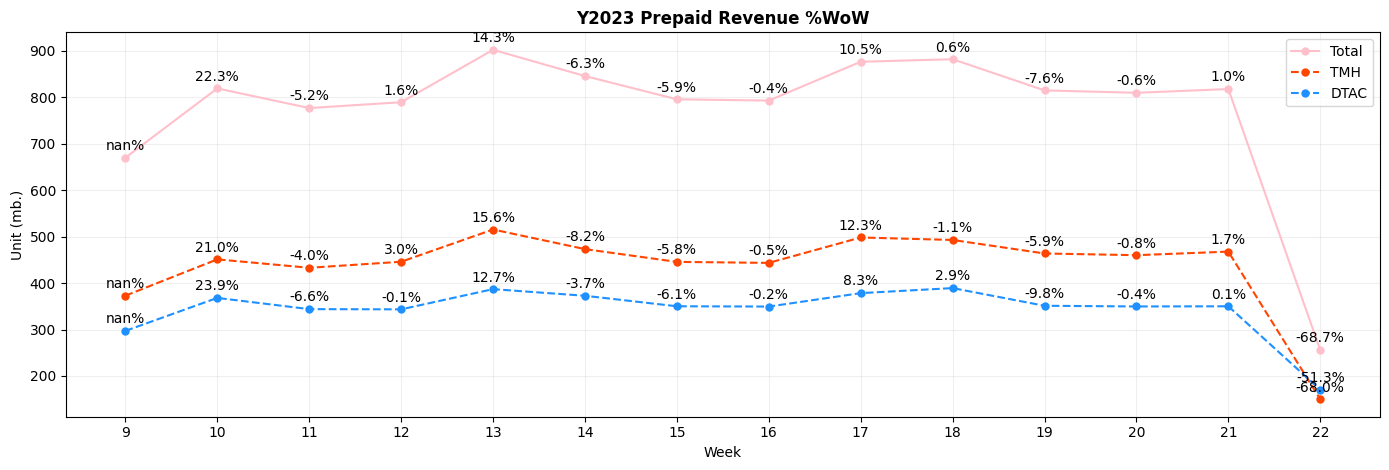

In [19]:
''' Revenue %WoW '''
plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Prepaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(f"{format(y_wow[i],',.1%')}", xy=(x_axis[i], y_act[i]+10), ha='center', va='bottom')
    plt.annotate(f"{format(y_wow_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+10), ha='center', va='bottom')
    plt.annotate(f"{format(y_wow_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+10), ha='center', va='bottom')
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### Prepaid Performance : %Achievement & Gap : WK

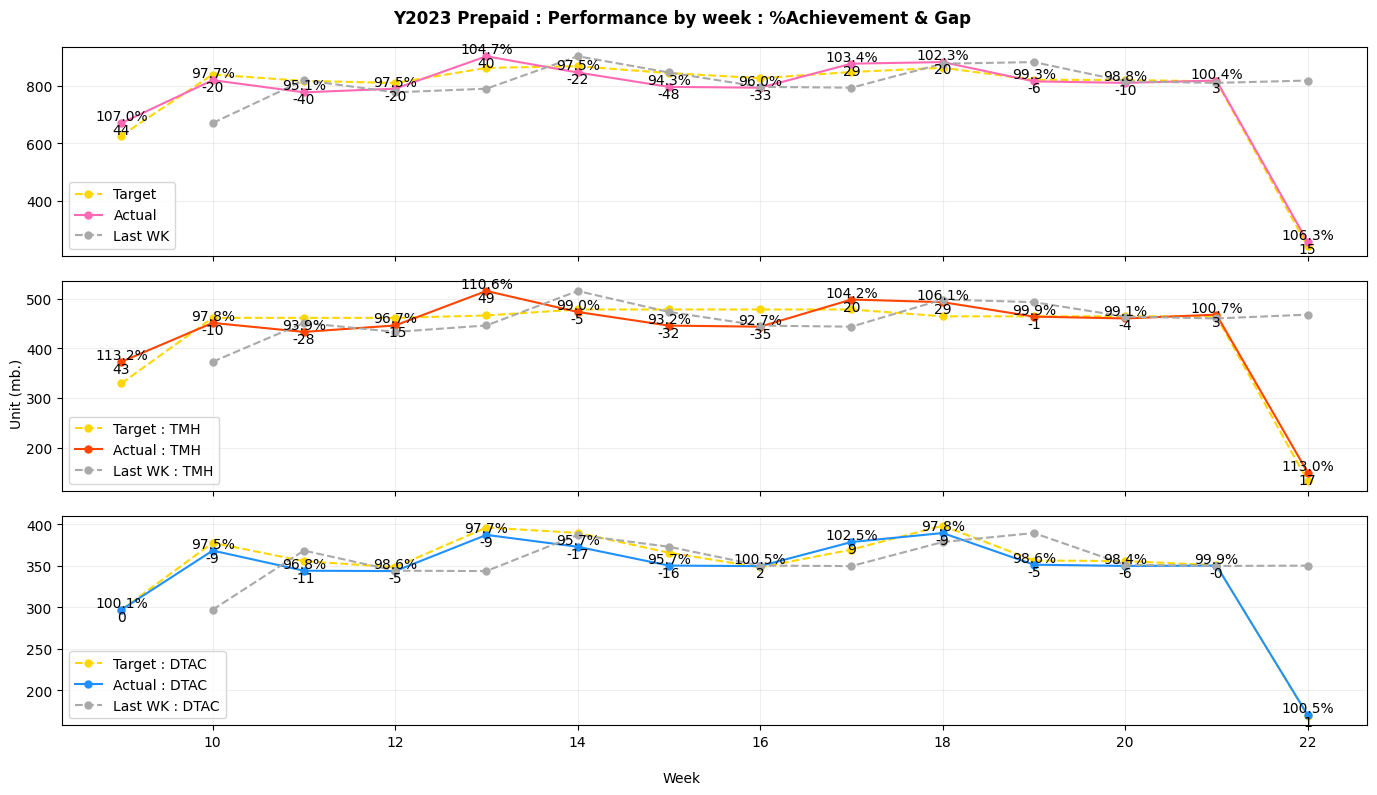

In [20]:
''' Peformance : %Achievement & Gap : Week Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Prepaid : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x, y_act, marker='.', markeredgewidth=3, label='Actual', color='hotpink')
ax1.plot(x, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend(loc='lower left')
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv[i],',.1%'), xy=(x[i], y_act[i]), ha='center', va='bottom')
    ax1.annotate(format(y_gap[i],',.0f'), xy=(x[i], y_act[i]), ha='center', va='top')

''' ax2 '''
ax2.plot(x, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK : TMH', color='darkgray')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_tmh[i],',.1%'), xy=(x[i], y_act_tmh[i]), ha='center', va='bottom')
    ax2.annotate(format(y_gap_tmh[i],',.0f'), xy=(x[i], y_act_tmh[i]), ha='center', va='top')

''' ax3 '''
ax3.plot(x, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK : DTAC', color='darkgray')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_dtac[i],',.1%'), xy=(x[i], y_act_dtac[i]), ha='center', va='bottom')
    ax3.annotate(format(y_gap_dtac[i],',.0f'), xy=(x[i], y_act_dtac[i]), ha='center', va='top')

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.show()